# Saving unattended data to zarr format in GCS bucket
This notebook saves the unattended ApRES data to a cloud optimized zarr format in a google cloud storage bucket. This is done to facilitate easier access to the data for analysis and visualization.

The five zarr directories are saved in `gs://ldeo-glaciology/apres/tg_archiving/` and named after the five unattended sites:

- unattended_LTG_L1.zarr
- unattended_Lake1_L1.zarr
- unattended_Lake2_L1.zarr
- unattended_Takahe1_204_L1.zarr
- unattended_Takahe2_203_L1.zarr



In [13]:
import xapres as xa
import xarray as xr
import os
import matplotlib.pyplot as plt
import rioxarray
import pandas as pd
import glob
import numpy as np
import json
import fsspec
import zarr

In [2]:
with open('../../ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)

In [3]:
sites = ["LTG", "Lake1", "Lake2", "Takahe1_204", "Takahe2_203"]
source = '/Users/jkingslake/Documents/data/thwaites_apres/archiving/level_1'
dest = "gs://ldeo-glaciology/apres/tg_archiving" 

In [4]:
def load(site):
    print(f"Loading from {source}, site: {site}")

    ds = xr.open_mfdataset(f"{source}/*{site}*.nc", engine="netcdf4")

    print (f"Dataset size: {ds.nbytes/1e9:.2f} GB")
    print(f"number of bursts: {ds.sizes['time']}")
    print(f"number of chirps: {ds.sizes['chirp_num']}")

    return ds

In [5]:
def add_stacked_profile(ds):
    print(f'adding stacked profile...')

    profile_stacked = ds.chirp_stacked.computeProfile(max_range=3000)
    return ds.assign({'profile_stacked': profile_stacked})

In [6]:
def load_and_chunk(site):
    ds = load(site)

    ds = add_stacked_profile(ds)
    ds = ds.drop_vars(['chirp', 'chirp_num'])

    return ds.chunk({'time': -1})

In [7]:
def save_to_zarr(site):
    ds = load_and_chunk(site)
    dest_filename = f"{dest}/unattended_{site}_L1.zarr"

    print(f'Chunking and saving zarr to {dest_filename}...')
    mapper = fsspec.get_mapper(dest_filename, mode='w', token=token)
    ds.to_zarr(mapper)
    zarr.consolidate_metadata(mapper)
    del ds


In [8]:
for site in sites:
    save_to_zarr(site)

Loading from /Users/jkingslake/Documents/data/thwaites_apres/archiving/level_1, site: LTG
Dataset size: 11.34 GB
number of bursts: 351
number of chirps: 100
adding stacked profile...
Chunking and saving zarr to gs://ldeo-glaciology/apres/tg_archiving/unattended_LTG_L1.zarr...
Loading from /Users/jkingslake/Documents/data/thwaites_apres/archiving/level_1, site: Lake1
Dataset size: 11.70 GB
number of bursts: 362
number of chirps: 100
adding stacked profile...
Chunking and saving zarr to gs://ldeo-glaciology/apres/tg_archiving/unattended_Lake1_L1.zarr...
Loading from /Users/jkingslake/Documents/data/thwaites_apres/archiving/level_1, site: Lake2
Dataset size: 23.16 GB
number of bursts: 360
number of chirps: 200
adding stacked profile...
Chunking and saving zarr to gs://ldeo-glaciology/apres/tg_archiving/unattended_Lake2_L1.zarr...
Loading from /Users/jkingslake/Documents/data/thwaites_apres/archiving/level_1, site: Takahe1_204
Dataset size: 11.77 GB
number of bursts: 364
number of chirps: 

## Load these data using xarray

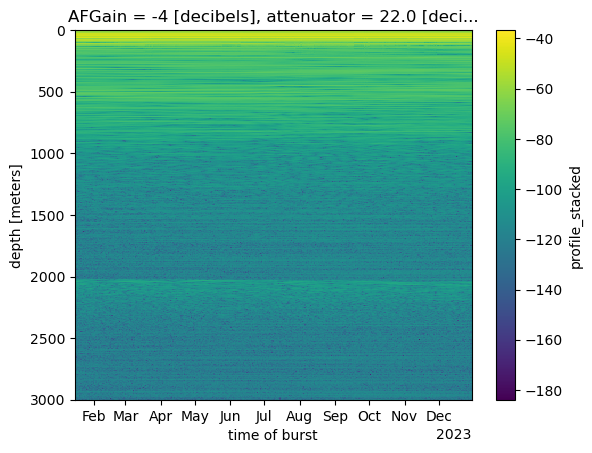

In [11]:
ds = xr.open_dataset("gs://ldeo-glaciology/apres/tg_archiving/unattended_LTG_L1.zarr", engine="zarr", chunks ={})
ds.profile_stacked.dB().plot(x = 'time', ylim = (3000, 0))

## Use xapres to compute strain rates 

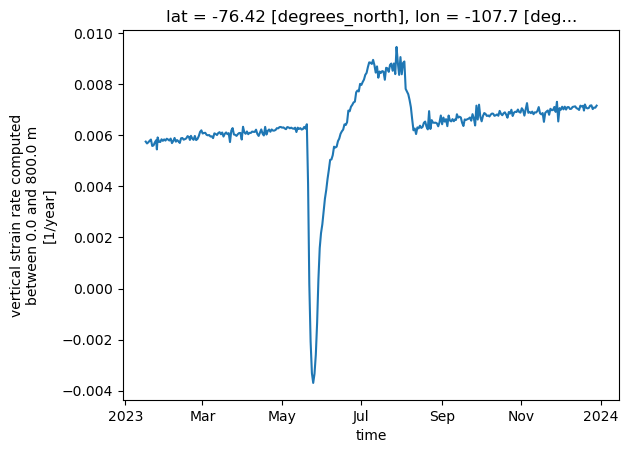

In [12]:
ds.profile_stacked.displacement_timeseries().strain_rate.plot()